In [2]:
from scipy.io import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data, meta = arff.loadarff(r"C:\Users\nico_\Desktop\projet csv\MNIST\mnist_784.arff")

X = np.array(data.tolist())

y = X[:, -1]

X = X[:, :-1]

In [4]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (70000, 784)
Shape of y: (70000,)


In [5]:
X

array([[b'0.0', b'0.0', b'0.0', ..., b'0.0', b'0.0', b'0.0'],
       [b'0.0', b'0.0', b'0.0', ..., b'0.0', b'0.0', b'0.0'],
       [b'0.0', b'0.0', b'0.0', ..., b'0.0', b'0.0', b'0.0'],
       ...,
       [b'0.0', b'0.0', b'0.0', ..., b'0.0', b'0.0', b'0.0'],
       [b'0.0', b'0.0', b'0.0', ..., b'0.0', b'0.0', b'0.0'],
       [b'0.0', b'0.0', b'0.0', ..., b'0.0', b'0.0', b'0.0']],
      dtype='|S32')

In [6]:
X = X.astype(float)
y = y.astype(int)

In [7]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")

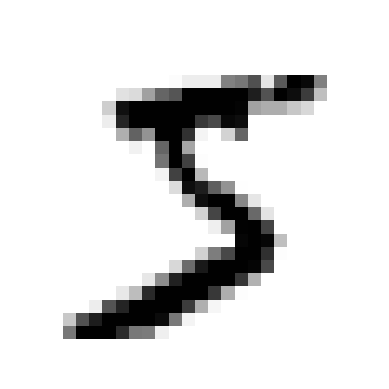

In [8]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

5

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Classificateur binaire (5)

In [11]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [12]:
from sklearn.linear_model import SGDClassifier

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# Validation croisée

In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
# k=3
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Accuracy = 95% mais le 5 représente environ 10% donc l'accuracy n'est pas la bonne métrique

# Matrice de confusion

In [17]:
from sklearn.model_selection import cross_val_predict

Utilisation du cross_val_predict pour renvoyer les prédiction faites pour chaque bloc de test

In [18]:
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)

In [19]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
cm = confusion_matrix(y_train_5,y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

vrai négatif = 53892

faux positif = 687 (erreur type 1)

vrai positif = 3530

faux négatif = 1891 (erreur type 2)

# Score de précision

TP/(TP+FP)

In [22]:
from sklearn.metrics import precision_score

In [23]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

# Score de rappel

TP/(TP+FN)

In [24]:
from sklearn.metrics import recall_score

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Le modèle a raison à 84% quand il déclare qu'une image est un 5 et ne détecte que 65% des 5.

# F1 score

2x(précisionxrappel/précision+rappel)

In [26]:
from sklearn.metrics import f1_score

In [27]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Les images sont classées par rapport au seuil du classificateur, plus le seuil est élevé, plus le rappel est bas et la précision plus élevée.

# Score de décision

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Calcul de la précision et du rappel pour tous les seuils possibles

In [29]:
from sklearn.metrics import precision_recall_curve

In [30]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

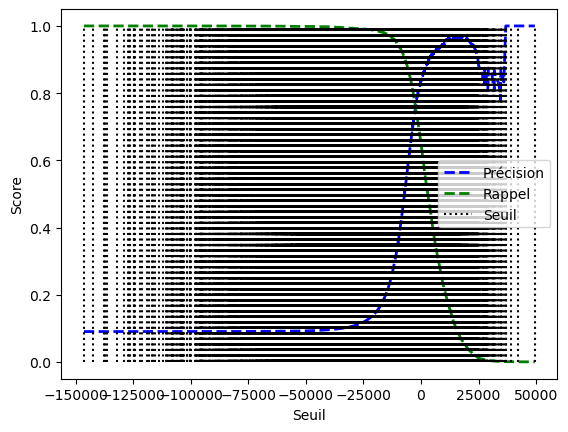

In [31]:
plt.plot(thresholds, precisions[:-1], "b--", label="Précision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g--", label="Rappel", linewidth=2)
plt.vlines(thresholds, 0, 1.0, "k", "dotted", label="Seuil")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.legend()
plt.show()

# Croisement précision/rappel

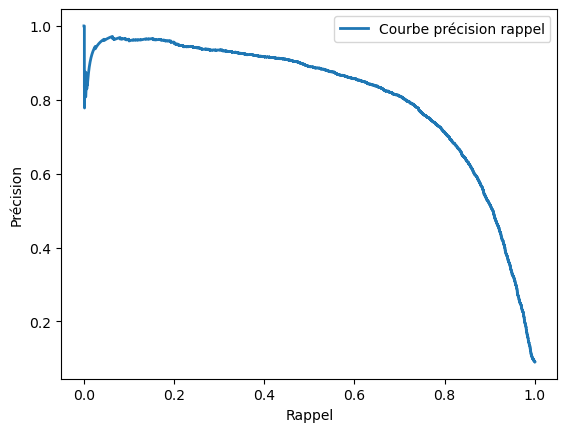

In [32]:
plt.plot(recalls, precisions, linewidth=2, label="Courbe précision rappel")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.legend()
plt.show()

Nous pouvons voir que la précision chutte brutalement à partir d'environ 80% de rappel. Pour faire un compromis, nous pourrions obtenir 80% de précision et 60% de rappel.

Pour un score de précision supérieur ou égal à 90%:

In [33]:
thresholds_for_90_precision = thresholds[(precisions >=0.9).argmax()]
thresholds_for_90_precision

3370.0194991439557

Le seuil pour obtenir un score de précision de 0.9 est de 3370.02

# Courbe ROC

In [34]:
from sklearn.metrics import roc_curve

In [35]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Avec une précision de 90%

In [36]:
idx_for_threshold_at_90 = (thresholds <= thresholds_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

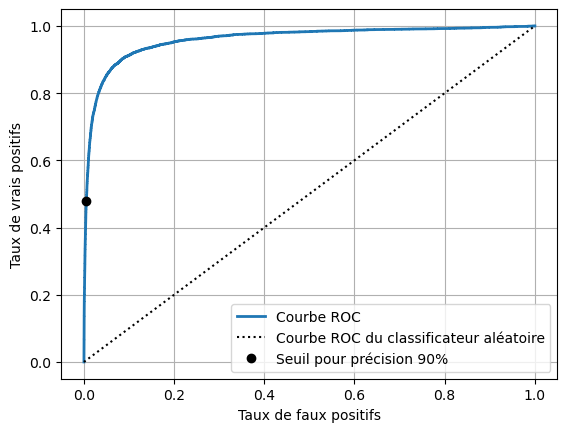

In [37]:
plt.plot(fpr,tpr,linewidth=2, label="Courbe ROC")
plt.plot([0,1], [0,1], "k:", label="Courbe ROC du classificateur aléatoire")
plt.plot([fpr_90], [tpr_90], "ko", label="Seuil pour précision 90%")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.grid()
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# RandomForestClassifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
forest_clf = RandomForestClassifier(random_state=42)

In [41]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [42]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

Le modèle prédit que la première image est positive à 89% et la deuxième, négative à 99%

In [43]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

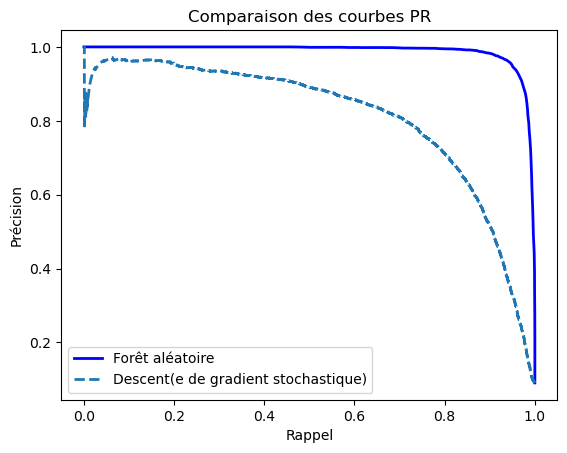

In [45]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Forêt aléatoire")
plt.plot(recalls, precisions, "--", linewidth=2, label="Descent(e de gradient stochastique)")
plt.title("Comparaison des courbes PR")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.legend()
plt.show()

Le RandomForestClassifier est supérieur au SGDClassifier 

In [56]:
y_train_pred_forest = y_probas_forest[:,1] >=0.5

In [59]:
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [60]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [61]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [62]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

Au vue des métriques, le modèle RandomForestClassifier est beaucoup plus performant que celui du SGDClassifier.